In [69]:
import os
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from models.position_encoding import PositionEmbeddingSine
from models.backbone import Backbone, Joiner
from models.transformer import Transformer
from models.detr import DETR
import util.misc as utils

from datasets.coco import CocoDetection_query, make_coco_transforms

In [70]:
device      = torch.device('cuda')
hidden_dim = 256
N_steps = 256 // 2
position_embedding = PositionEmbeddingSine(N_steps)
backbone = Backbone(name                 = 'resnet50',
                    train_backbone       = False,
                    return_interm_layers = False,
                    dilation             = False)
backbone_ = Joiner(backbone, position_embedding)
backbone_.num_channels = backbone.num_channels

transformer = Transformer(
        d_model=hidden_dim,
        dropout=0.1,
        nhead=8,
        dim_feedforward=2048,
        num_encoder_layers=6,
        num_decoder_layers=6,
        normalize_before=False,
        return_intermediate_dec=True,
    )


model = DETR(
    backbone_,
    transformer,
    num_classes = 21,
    num_queries = 100,
    aux_loss    = False,
)

checkpoint = torch.load('/home/ubuntu/detr/results/voc2009/checkpoint.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])
#model.to(device)


<All keys matched successfully>

In [71]:
coco_path = '/home/ubuntu/admin_dataprep/external/voc2009/'
image_set = 'test'

prob = os.path.basename(os.path.dirname(coco_path))
img_folder = os.path.join(coco_path, f'{prob}_full', str(image_set.split('_')[0]))
ann_file = os.path.join(coco_path, 'labels_full', 'coco', f'coco_{image_set}.json')
dataset = CocoDetection_query(img_folder, ann_file, transforms=make_coco_transforms(image_set.split('_')[0]), return_masks=False)
sampler   = torch.utils.data.RandomSampler(dataset)
data_loader   = DataLoader(dataset,
                           1,
                           sampler      = sampler,
                           drop_last    = False,
                           collate_fn   = utils.collate_fn_query,
                           num_workers  = 2)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


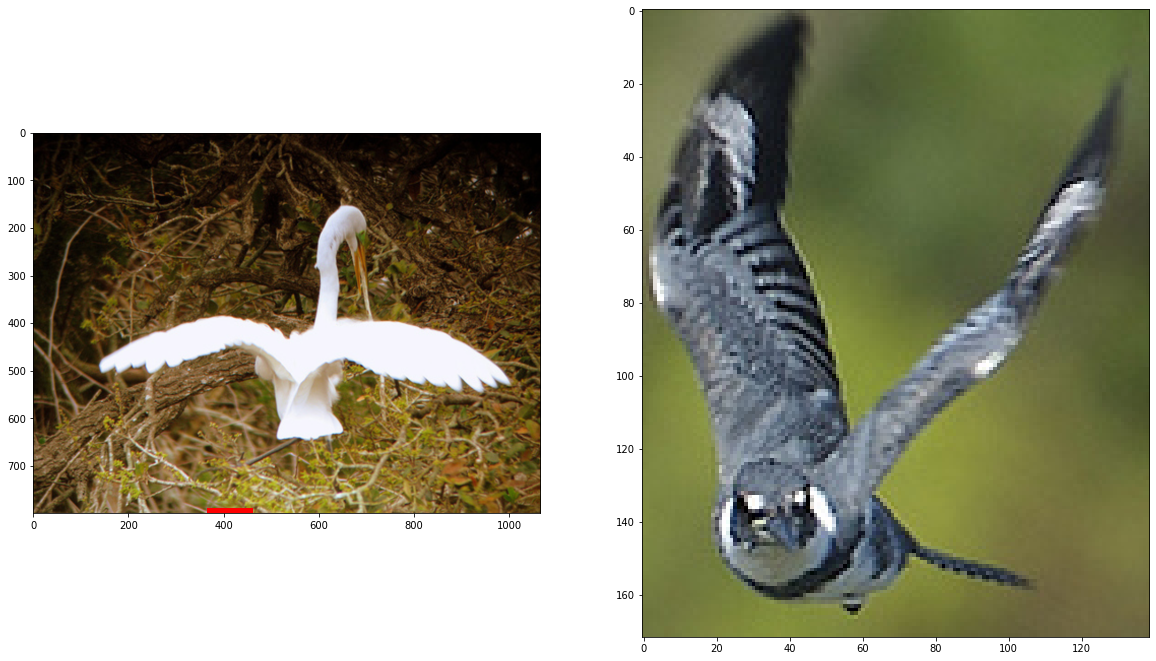

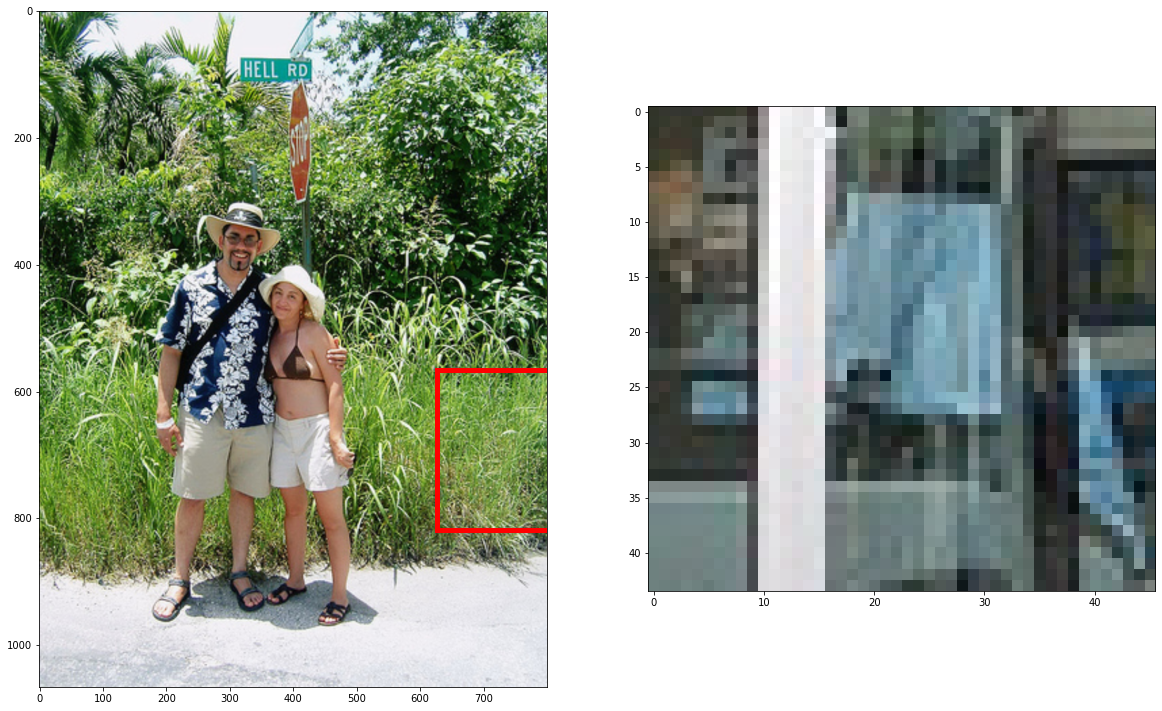

In [72]:
def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
denorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

for i, (img, gt, query) in enumerate(data_loader):
    model.eval()
    #outputs = model(img.to(device), query.to(device))
    outputs = model(img, query)

    out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']
    prob = F.softmax(out_logits, -1)
    scores, labels = prob[..., :-1].max(-1)
    idx = scores.argsort().cpu().detach().numpy()[0][0]
    bbox  = out_bbox.cpu().detach()[0][idx]
    bbox = box_xyxy_to_cxcywh(bbox)
    c,img_w,img_h = img.tensors[0].shape
    
    fig, ax = plt.subplots(1,2, figsize=(20,40))

    ax[0].imshow(denorm(img.tensors[0]).permute(1,2,0))
    ax[1].imshow(denorm(query.tensors[0]).permute(1,2,0))
    
    rect = patches.Rectangle((bbox[0]*img_w,
                              bbox[1]*img_h),
                              bbox[2]*img_w,
                              bbox[3]*img_h,
                              linewidth=5,
                              edgecolor='r',
                              facecolor='none')

    # Add the patch to the Axes
    ax[0].add_patch(rect)
    if i == 1:
        break


In [59]:
import torchvision
import torch
import numpy as np
from PIL import Image

import os

class CocoDetection_query(torchvision.datasets.CocoDetection):
    """
    this is the torchvision dataset which provides a query image to match the single category
    of bounding boxes which is returned on each iteration.
    """
    def __init__(self, img_folder, ann_file, transforms, return_masks):
        super(CocoDetection_query, self).__init__(img_folder, ann_file)
        self.image_transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)

        # Query SEt
        
        self.query_set       = {k: [] for k in self.coco.cats.keys()}
        
        for k, v in self.coco.anns.items():
            self.query_set[v['category_id']].append({'image_id': v['image_id'], 'bbox': v['bbox'], 'id': v['id']})
        self.obj_of_interest = np.random.choice(list(self.query_set.keys()))


    def __getitem__(self, idx):

        img, target = super(CocoDetection_query, self).__getitem__(idx)

        # pick one class per image and limit targets to that class
        #cat_id = np.random.choice([t['category_id'] for t in target])
        print(target, self.obj_of_interest)
        target = [t for t in target if t['category_id'] == self.obj_of_interest]
        if len(target) > 0:
            print("target", target)
        #target = [t for t in target if t['category_id'] == cat_id]
        # get query image (not from same image)
        image_id = self.ids[idx]
        annot_id = image_id
        while annot_id == image_id:
            query = np.random.choice(self.query_set[self.obj_of_interest])
            annot_id = query['image_id']
        path = self.coco.loadImgs(annot_id)[0]['file_name']
        query_img = np.array(Image.open(os.path.join(self.root, path)).convert('RGB'))

        # crop to only bbox
        x, y, w, h = query['bbox']
        query_img = query_img[int(y):int(y + h), int(x):int(x + w), :]

        # process org image and target
        target = {'image_id': image_id, 'annotations': target}
        img, target = self.prepare(img, target)
        return img, target, query_img

class ConvertCocoPolysToMask(object):
    def __init__(self, return_masks=False):
        self.return_masks = return_masks

    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        if self.return_masks:
            masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        if self.return_masks:
            target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target
    
def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

def build_lwll(image_set='train', coco_path='/home/ubuntu/admin_dataprep/external/voc2009/'):
    prob = os.path.basename(os.path.dirname(coco_path))
    img_folder = os.path.join(coco_path, f'{prob}_full', str(image_set.split('_')[0]))
    ann_file = os.path.join(coco_path, 'labels_full', 'coco', f'coco_{image_set}.json')
    dataset = CocoDetection_query(img_folder, ann_file, transforms='this', return_masks=False)
    return dataset

In [60]:
dataset = build_lwll()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [61]:
for i in range(100):
    print('this')
    dataset[i]

this
[{'id': 13429, 'image_id': 0, 'category_id': 14, 'area': 43750, 'bbox': [174, 101, 175, 250], 'iscrowd': 0}] 11
this
[{'id': 2002, 'image_id': 1, 'category_id': 0, 'area': 28455, 'bbox': [104, 78, 271, 105], 'iscrowd': 0}, {'id': 2003, 'image_id': 1, 'category_id': 0, 'area': 2240, 'bbox': [133, 88, 64, 35], 'iscrowd': 0}, {'id': 2004, 'image_id': 1, 'category_id': 14, 'area': 882, 'bbox': [195, 180, 18, 49], 'iscrowd': 0}, {'id': 2005, 'image_id': 1, 'category_id': 14, 'area': 882, 'bbox': [26, 189, 18, 49], 'iscrowd': 0}] 11
this
[{'id': 2880, 'image_id': 2, 'category_id': 0, 'area': 76440, 'bbox': [9, 107, 490, 156], 'iscrowd': 0}, {'id': 2881, 'image_id': 2, 'category_id': 0, 'area': 1586, 'bbox': [421, 200, 61, 26], 'iscrowd': 0}, {'id': 2882, 'image_id': 2, 'category_id': 0, 'area': 3010, 'bbox': [325, 188, 86, 35], 'iscrowd': 0}] 11
this
[{'id': 7118, 'image_id': 4, 'category_id': 18, 'area': 62331, 'bbox': [263, 32, 237, 263], 'iscrowd': 0}, {'id': 7119, 'image_id': 4, 'ca

this
[{'id': 8370, 'image_id': 42, 'category_id': 14, 'area': 240, 'bbox': [394, 199, 10, 24], 'iscrowd': 0}, {'id': 8371, 'image_id': 42, 'category_id': 14, 'area': 252, 'bbox': [424, 199, 12, 21], 'iscrowd': 0}, {'id': 8372, 'image_id': 42, 'category_id': 14, 'area': 240, 'bbox': [434, 196, 10, 24], 'iscrowd': 0}, {'id': 8373, 'image_id': 42, 'category_id': 14, 'area': 225, 'bbox': [443, 195, 9, 25], 'iscrowd': 0}, {'id': 8374, 'image_id': 42, 'category_id': 5, 'area': 49572, 'bbox': [29, 113, 324, 153], 'iscrowd': 0}, {'id': 8375, 'image_id': 42, 'category_id': 0, 'area': 15476, 'bbox': [328, 86, 146, 106], 'iscrowd': 0}, {'id': 8376, 'image_id': 42, 'category_id': 6, 'area': 572, 'bbox': [2, 213, 26, 22], 'iscrowd': 0}] 11
this
[{'id': 1681, 'image_id': 43, 'category_id': 17, 'area': 21412, 'bbox': [119, 177, 212, 101], 'iscrowd': 0}, {'id': 1682, 'image_id': 43, 'category_id': 15, 'area': 11235, 'bbox': [65, 90, 105, 107], 'iscrowd': 0}, {'id': 1683, 'image_id': 43, 'category_id':

this
[{'id': 8790, 'image_id': 87, 'category_id': 16, 'area': 22002, 'bbox': [208, 78, 193, 114], 'iscrowd': 0}, {'id': 8791, 'image_id': 87, 'category_id': 16, 'area': 20336, 'bbox': [19, 71, 164, 124], 'iscrowd': 0}, {'id': 8792, 'image_id': 87, 'category_id': 16, 'area': 17160, 'bbox': [1, 106, 120, 143], 'iscrowd': 0}, {'id': 8793, 'image_id': 87, 'category_id': 16, 'area': 46189, 'bbox': [1, 185, 323, 143], 'iscrowd': 0}, {'id': 8794, 'image_id': 87, 'category_id': 16, 'area': 11360, 'bbox': [330, 26, 142, 80], 'iscrowd': 0}, {'id': 8795, 'image_id': 87, 'category_id': 16, 'area': 27225, 'bbox': [27, 13, 225, 121], 'iscrowd': 0}] 11
this
[{'id': 1646, 'image_id': 88, 'category_id': 12, 'area': 23828, 'bbox': [192, 109, 148, 161], 'iscrowd': 0}, {'id': 1647, 'image_id': 88, 'category_id': 14, 'area': 15604, 'bbox': [281, 80, 83, 188], 'iscrowd': 0}, {'id': 1648, 'image_id': 88, 'category_id': 15, 'area': 10112, 'bbox': [436, 148, 64, 158], 'iscrowd': 0}] 11
this
[{'id': 8683, 'imag